Ishod 5

Martin Plaftarić

Dataset 38

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

file = 'PRSA_Data_Dingling.csv'
target_variable = "Bad_air"
features = ["PM2.5","PM10","SO2","NO2","CO","O3"]
air_pollution_data = {}

# Dataset header
# "No","year","month","day","hour","PM2.5","PM10","SO2","NO2","CO","O3","TEMP","PRES","DEWP","RAIN","wd","WSPM","station"

# Air Pollution Variables
# PM2.5 – Fine particulate matter (diameter ≤ 2.5µm)
# PM10 – Coarse particulate matter (diameter ≤ 10µm)
# SO2 Sulfur Dioxide
# NO2 Nitrogen Dioxide
# CO Carbon Monoxide
# O3 Ozone

# Meteorological Variables
# TEMP Temperature
# PRES Pressure
# DEWP Dew Point Temperature
# RAIN Rainfall(mm)
# wd Wind Direction
# WSPM Wind Speed in Meters per Second

### Load data ###
try:
    air_pollution_data = pd.read_csv(file)
    #air_pollution_data["datetime"] = pd.to_datetime(
    #    air_pollution_data[['year', 'month', 'day', 'hour']])
    # Only take the needed variables for the target variable
    air_pollution_data = air_pollution_data.drop(columns=['No','station']) #drop No and station columns
except FileNotFoundError:
    print(f"Error: The file '{file}' was not found.")
    exit()

### Checking for missing values ###
def check_missing_values():
    print("\nMissing Values Per Column:")
    print(air_pollution_data.isnull().sum())

check_missing_values()

# Show the columns with missing values for manual inspection
#print(air_pollution_data[air_pollution_data["PM2.5"].isna()])
#print(air_pollution_data[air_pollution_data["SO2"].isna()])
#print(air_pollution_data[air_pollution_data["NO2"].isna()])
#print(air_pollution_data[air_pollution_data["CO"].isna()])
#print(air_pollution_data[air_pollution_data["O3"].isna()])

# Recode missing values with cbr(euclid distance)
def cbr_recode_missing(data, column):
    
    missing = data[data[column].isnull()].index.tolist()
    if not missing:
        print(f"No missing values found in column '{column}'.")
        return data

    print(f"Attempting to recode missing values in column '{column}' using CBR with Euclidean distance...")
    
    for index in missing:
        # Find similar cases
        similar_cases = data.drop(index).dropna(subset=[column])  # Drop the current row and rows with NaN in target column

        if similar_cases.empty:
            print(f"No similar cases found for index {index}. Filling with 'missing'.")
            data.loc[index, column] = 'missing'
            continue

        # Prepare data for Euclidean distance calculation
        numerical_cols = data.select_dtypes(include=np.number).columns.tolist()
        numerical_cols = [col for col in numerical_cols if col != column and col in data.columns]  # Remove target column
        if not numerical_cols:
            print(f"No numerical columns available to determine similarity for index {index}. Filling with 'missing'.")
            data.loc[index, column] = 'missing'
            continue

        # Scale numerical features
        try:
            # Input missing values with the mean
            means = data[numerical_cols].mean()
            input_data = data[numerical_cols].fillna(means)

            # Scale the data
            scaled_data = (input_data - means) / input_data.std()

        except Exception as e:
            print(f"Error scaling data: {e}. Filling with 'missing'.")
            data.loc[index, column] = 'missing'
            continue

        current_case = scaled_data.loc[index, numerical_cols].values

        # Calculate Euclidean distances
        similar_cases_indices = similar_cases.index.tolist()

        try:
            similar_cases_scaled = scaled_data.loc[similar_cases_indices, numerical_cols].values
            distances = np.sqrt(np.sum((current_case - similar_cases_scaled)**2, axis=1))

        except Exception as e:
            print(f"Error calculating distances: {e}. Filling with 'missing'.")
            data.loc[index, column] = 'missing'
            continue

        # Find the most similar case (minimum distance)
        most_similar_index = similar_cases_indices[np.argmin(distances)]
        most_similar_value = similar_cases.loc[most_similar_index, column]

        # Assign the value from the most similar case
        data.loc[index, column] = most_similar_value

    return data

# Apply CBR recoding (Euclidean distance) to each column with missing values
for col in air_pollution_data.columns:
    if air_pollution_data[col].isnull().any():
        air_pollution_data = cbr_recode_missing(air_pollution_data, col)

check_missing_values()

# Create target variable: Which variables are indicators of bad air quality. 
# Thresholds taken from the World Health Organization (WHO) guidelines.
air_pollution_data['Bad_air'] = 0 # 0 for NO
air_pollution_data.loc[
    (air_pollution_data['PM2.5'] > 75) | 
    (air_pollution_data['PM10'] > 150) | 
    (air_pollution_data['SO2'] > 150) | 
    (air_pollution_data['NO2'] > 200) | 
    (air_pollution_data['CO'] > 1000) | 
    (air_pollution_data['O3'] > 160), 
    'Bad_air'
] = 1 # 1 for YES

observed_variables=['PM2.5','PM10','SO2','NO2','CO','O3']

air_pollution_data[observed_variables].corr()


Missing Values Per Column:
year        0
month       0
day         0
hour        0
PM2.5     779
PM10      656
SO2       730
NO2      1234
CO       2012
O3       1214
TEMP       53
PRES       50
DEWP       53
RAIN       51
wd        140
WSPM       43
dtype: int64
Attempting to recode missing values in column 'PM2.5' using CBR with Euclidean distance...
Attempting to recode missing values in column 'PM10' using CBR with Euclidean distance...
Attempting to recode missing values in column 'SO2' using CBR with Euclidean distance...
Attempting to recode missing values in column 'NO2' using CBR with Euclidean distance...
Attempting to recode missing values in column 'CO' using CBR with Euclidean distance...
Attempting to recode missing values in column 'O3' using CBR with Euclidean distance...
Attempting to recode missing values in column 'TEMP' using CBR with Euclidean distance...
Attempting to recode missing values in column 'PRES' using CBR with Euclidean distance...
Attempting to recode

,PM2.5,PM10,SO2,NO2,CO,O3
PM2.5,1.000000,0.861663,0.473187,0.718858,0.789746,-0.099236
PM10,0.861663,1.000000,0.447428,0.646082,0.672015,-0.018149
SO2,0.473187,0.447428,1.000000,0.611736,0.520502,-0.184326
NO2,0.718858,0.646082,0.611736,1.000000,0.776920,-0.370440
CO,0.789746,0.672015,0.520502,0.776920,1.000000,-0.295177
O3,-0.099236,-0.018149,-0.184326,-0.370440,-0.295177,1.000000


First we check than fill any missing values by using Case-Based Reasoning (CBR) with the Euclidean distance to calculate the approximate values.

In the Beijing Multi-Site Air Quality Dataset (Pingling station), the target variable (Bad_air) is a binary indicator that checks whether any of the pillution variables concentrations breach the thresholds set by the World Health Organization (WHO) guidelines. If any variables breach these thresholds, the air is classified as poor quality, indicating potential harm to human health.

The simplest way to check the quality of our target variable is by checking the correlation betweene the variables. As we can see PM2.5 correlates the most with the other variables. This is also why it is generally used as the main indicator of poor air quality.


Categorical Columns:  ['wd']
Numerical Columns:  ['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

Categorical Variable Analysis: 

Frequency Distribution for wd:
wd
NNW    4795
NW     3868
N      3791
WNW    2883
ESE    2791
E      2433
NNE    1925
SSE    1855
SE     1826
NE     1731
S      1701
W      1422
ENE    1313
SSW    1129
SW      894
WSW     707
Name: count, dtype: int64


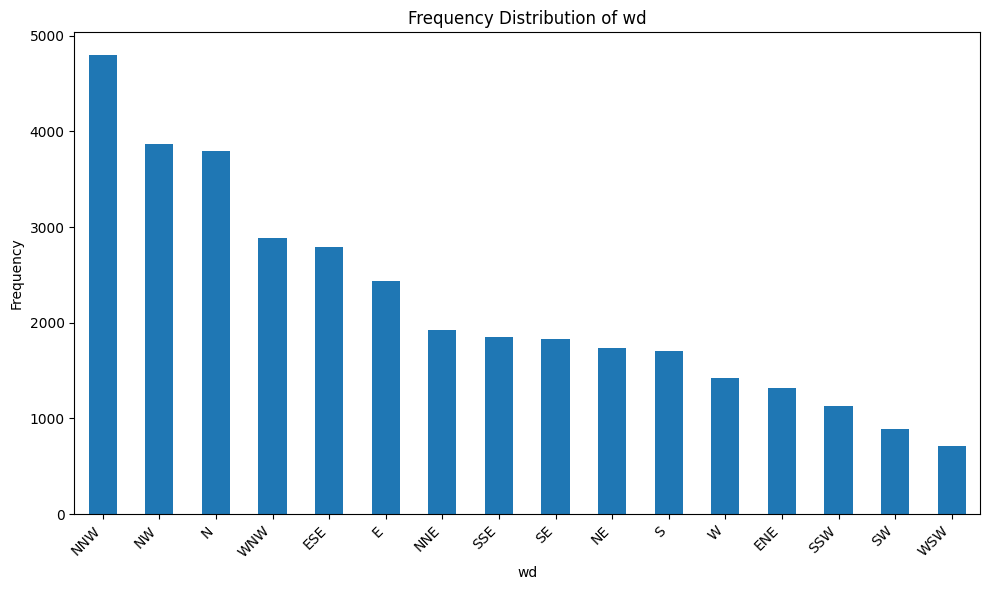

  Mean: 2014.66
  Standard Deviation: 1.18
  Skewness: 0.05
  Kurtosis: -1.09


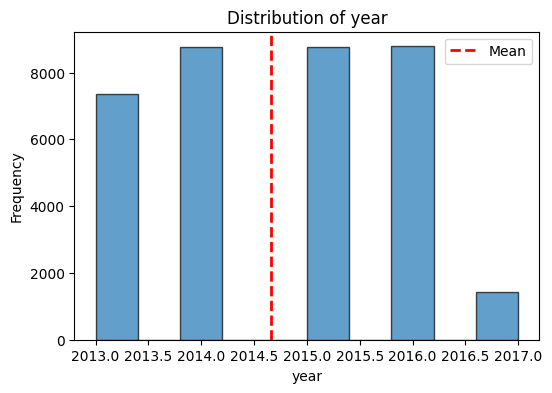

  Mean: 6.52
  Standard Deviation: 3.45
  Skewness: -0.01
  Kurtosis: -1.21


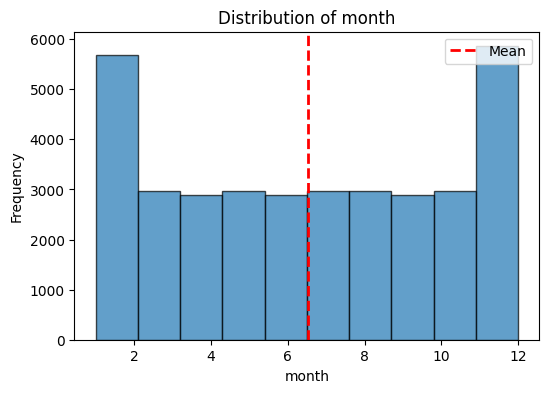

  Mean: 15.73
  Standard Deviation: 8.80
  Skewness: 0.01
  Kurtosis: -1.19


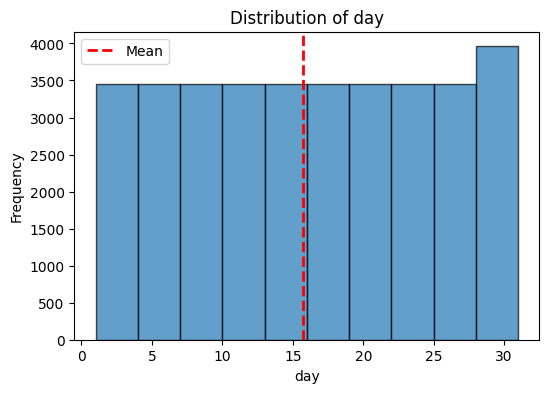

  Mean: 11.50
  Standard Deviation: 6.92
  Skewness: 0.00
  Kurtosis: -1.20


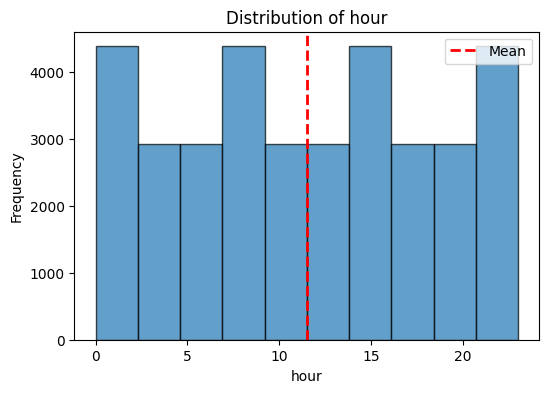

  Mean: 65.74
  Standard Deviation: 71.83
  Skewness: 2.02
  Kurtosis: 5.59


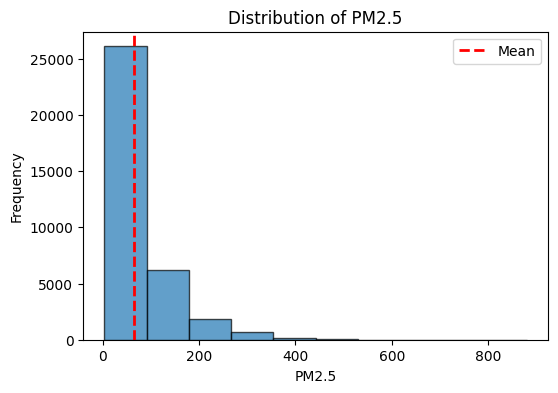

  Mean: 83.60
  Standard Deviation: 79.76
  Skewness: 2.18
  Kurtosis: 8.84


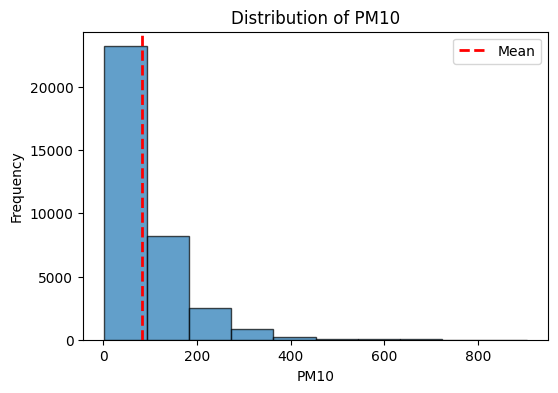

  Mean: 11.70
  Standard Deviation: 15.40
  Skewness: 2.79
  Kurtosis: 10.26


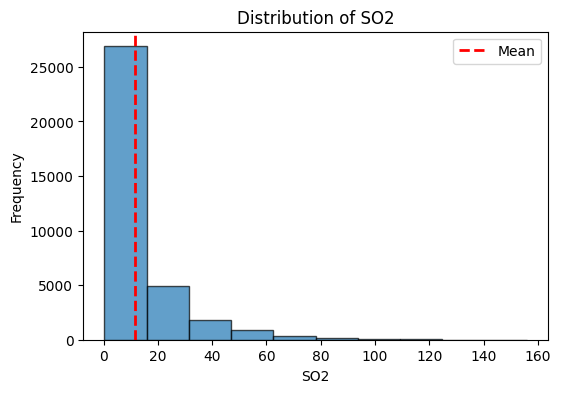

  Mean: 27.21
  Standard Deviation: 26.17
  Skewness: 1.72
  Kurtosis: 3.54


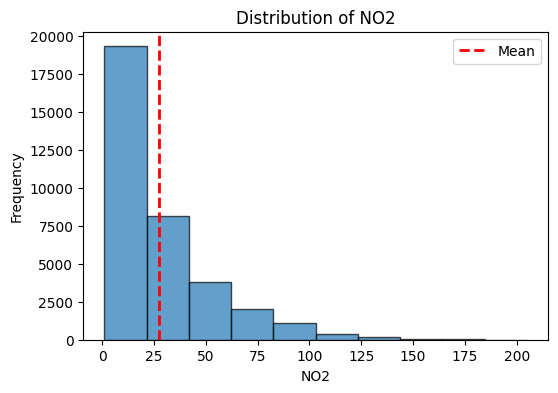

  Mean: 897.78
  Standard Deviation: 887.47
  Skewness: 2.84
  Kurtosis: 13.14


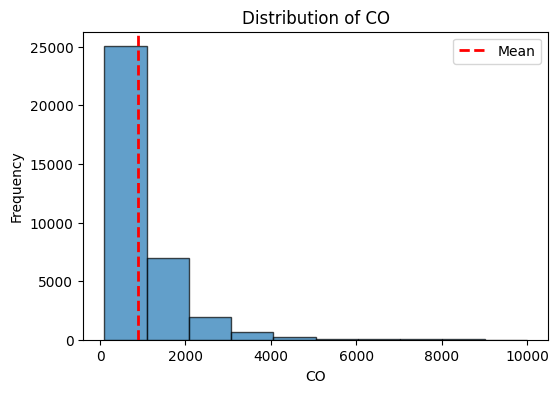

  Mean: 68.74
  Standard Deviation: 54.00
  Skewness: 1.61
  Kurtosis: 4.54


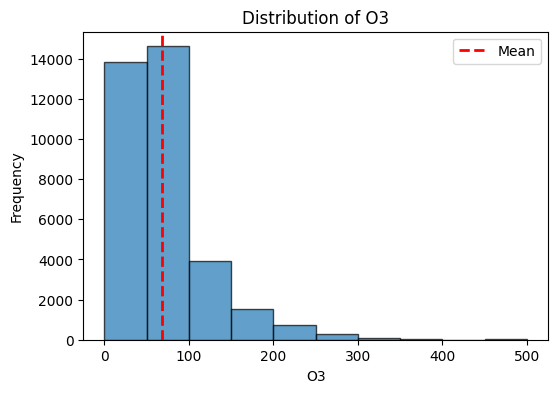

  Mean: 13.68
  Standard Deviation: 11.36
  Skewness: -0.10
  Kurtosis: -1.13


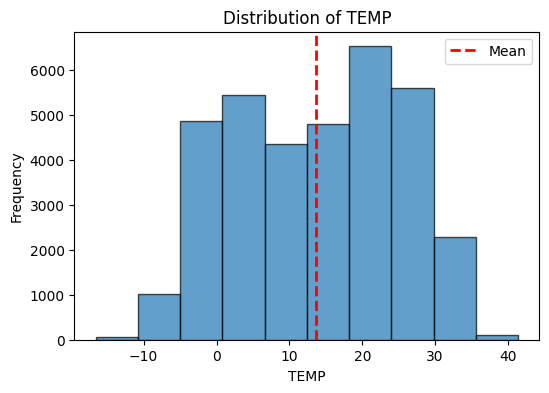

  Mean: 1007.76
  Standard Deviation: 10.22
  Skewness: 0.10
  Kurtosis: -0.92


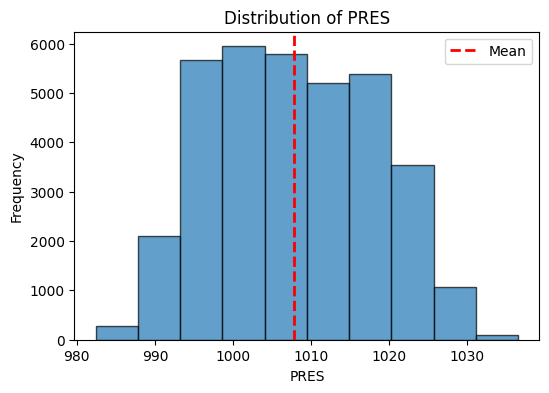

  Mean: 1.50
  Standard Deviation: 13.82
  Skewness: -0.15
  Kurtosis: -1.18


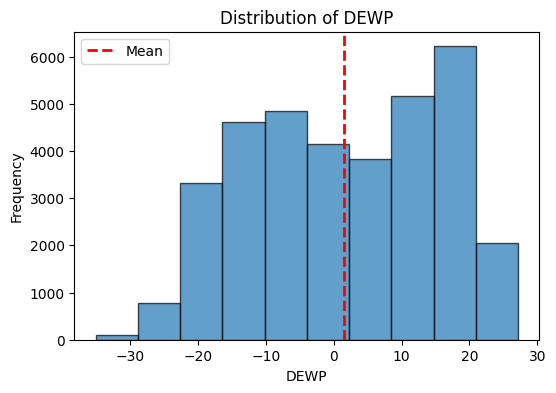

  Mean: 0.06
  Standard Deviation: 0.75
  Skewness: 29.59
  Kurtosis: 1272.65


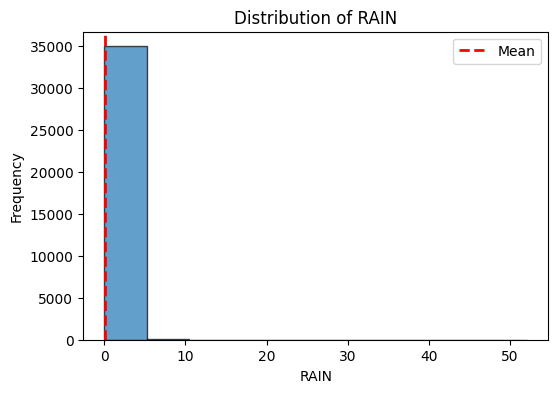

  Mean: 1.85
  Standard Deviation: 1.31
  Skewness: 1.66
  Kurtosis: 3.21


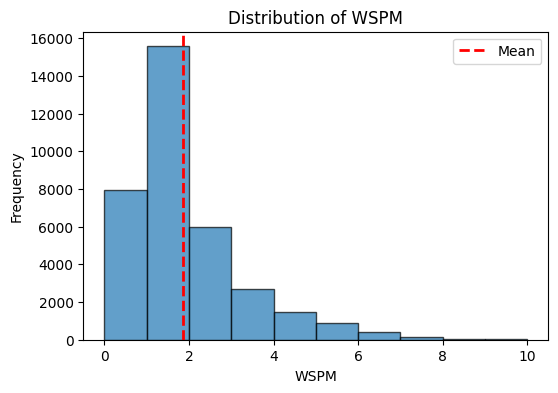


Correlations with the target Variable:


KeyError: 'Bad_air'

In [2]:
categorical_columns = []
numerical_columns = []
z_value_correlations = {} 

# Identify categorical and numerical columns
for col in air_pollution_data.columns:
    if air_pollution_data[col].dtype == 'object' and col != target_variable:
        categorical_columns.append(col)
    elif air_pollution_data[col].dtype in ['int64', 'float64'] and col != target_variable:
        numerical_columns.append(col)

print("Categorical Columns: ", categorical_columns)
print("Numerical Columns: ", numerical_columns)

def analyze_categorical_data(air_pollution_data, target_variable):
    # Categorical Variable Analysis
    print("\nCategorical Variable Analysis: ")
    for col in categorical_columns:
        print(f"\nFrequency Distribution for {col}:")
        print(air_pollution_data[col].value_counts())

        # Plotting frequency distribution
        plt.figure(figsize=(10, 6))
        air_pollution_data[col].value_counts().plot(kind='bar') 
        plt.title(f"Frequency Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
def analyze_continuous_data(air_pollution_data, target_variable):

    for col in numerical_columns:
        mean_value = air_pollution_data[col].mean()
        print(f"  Mean: {mean_value:.2f}")
        std_dev = air_pollution_data[col].std()
        print(f"  Standard Deviation: {std_dev:.2f}")
        z_scores = (air_pollution_data[col] - mean_value) / std_dev
        air_pollution_data[f'{col}_Z'] = z_scores
        skewness = air_pollution_data[col].skew()
        print(f"  Skewness: {skewness:.2f}")
        kurtosis = air_pollution_data[col].kurtosis()
        print(f"  Kurtosis: {kurtosis:.2f}")

        # Plot histogram and distribution
        plt.figure(figsize=(6, 4))
        plt.hist(air_pollution_data[col].dropna(), bins=10, edgecolor='black', alpha=0.7)
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

def correlation_data(air_pollution_data, target_variable):
    for col in numerical_columns:
        # Correlation with the target variable
        print("\nCorrelations with the target Variable:")
        correlations = air_pollution_data[numerical_columns].corr()[target_variable].sort_values(ascending=False)
        print(correlations)

def z_correlation_data(air_pollution_data, target_variable):
    # Z-Value Correlation Analysis
    print("\nZ-Value Correlation Analysis:")

    # Categorize Z values
    for col in numerical_columns:
        z_col = f"{col}_Z"
        if z_col in air_pollution_data.columns:

            air_pollution_data[f'{col}_Z_Cat'] = pd.cut(air_pollution_data[z_col], bins=[-float('inf'), -3, 3, float('inf')],
                                        labels=['<-3', '(-3 to 3)', '>3'])

            #Calculate correlation between the z score category and the target variable
            dummies = pd.get_dummies(air_pollution_data[f'{col}_Z_Cat']) #Create dummy variables for correlation

            #Calculate correlation between the category and the target variable
            for category in dummies.columns:
                correlation = dummies[category].corr(air_pollution_data[target_variable])
                z_value_correlations[f"{col}_Z_{category}"] = correlation #Store in the z score correlations

            print(f"\nZ-Value Categorized Correlations for {col} with {target_variable}:")
            for key in z_value_correlations:
                if col in key: #Only show correlations for the current column
                    print(f"{key}: {z_value_correlations[key]:.3f}") #Prints z score correlations

            air_pollution_data.drop(columns=[f'{col}_Z_Cat'], inplace=True) #cleanup for loop by removing the category
        else:
            print(f"Z-value column {z_col} does not exist.  Skipping.")

analyze_categorical_data(air_pollution_data, target_variable)
analyze_continuous_data(air_pollution_data, target_variable)
correlation_data(air_pollution_data, target_variable)
z_correlation_data(air_pollution_data, target_variable)

Data Analysis Results:

PM2.5 - A right-skewed trend of '2.01' tells us the pollution levels are mostly low with occasional high spikes. This is also confirmed by the mean '65.09' 

PM10 - A right-skewed trend of '2.17' tells us the pollution levels are mostly low with occasional high spikes. This is also confirmed by the mean '83.86' 

A similar right-skewed trend, ranging from '1.60' to '2.83', is seen in the air pollution variables "SO2", "NO2", "CO", "O3". 

TEMP, PRES and DEWP show slight left/right skewes of up to 0.14(left skew) and 0.10 (right skew), with expected distribution of values.

RAIN - Strong right-skew of 30.09 which tells us most of the time there was little to no rainfall(mean "0.06"). However, when it did rain, the amount could be significant.

WSPM - A right-skewed trend of '1.66' tells us the wind speed was mostly low with occasional strong winds. This is also confirmed by the mean '1.85' 

Wd - Categorically, we observe that winds mostly came from the NNW, NW, N, and WNW directions.

Correlation Results with target variable PM2.5:

Strong positive correlation (0 -> 1) 
Variables "PM10", "CO", "NO2", and "SO2" show a strong positive correlation with PM2.5, indicating that traffic emissions (SO2, NO2, CO) are major contributors to air pollution. As expected, PM10 (coarse particles) often accompanies PM2.5 (fine particles).

Weak positive correlation (0 -> 1) 
A weak positive correlation is observed in "DEWP". This is reasonable, as Dew Point Temperature (DEWP) slightly fluctuates due to additional particles in the air caused by pollution.

Negative correlation (-1 -> 0) Variables "TEMP", "O3", "WSPM", "RAIN", and "PRES" negatively correlate with PM2.5, as these factors contribute to particle dispersion. example: stronger winds stop the air quality from being saturated by harmfull particles.

Interesting - "hour" Correlation (0.040041)
While "hour" itself does not directly impact air quality, its correlation suggests that business hours correlate with higher air pollution levels, likely due to increased traffic and industrial activity.

Analysis of Z-score correlations confirms that "PM10", "CO", "NO2", and "SO2" tend to spike simultaneously with PM2.5, reinforcing the idea that common pollution sources (vehicles, industry) drive high pollution levels. Conversely, "WSPM" (wind speed) and "RAIN" help disperse pollutants, reducing air pollution levels.


Information Value for year_binned: 0.00
Information Value for month_binned: 0.03
Information Value for day_binned: 0.01
Information Value for hour_binned: 0.02
Information Value for PM2.5_binned: 6.67
Information Value for PM10_binned: 3.30
Information Value for SO2_binned: 0.34
Information Value for NO2_binned: 1.31
Information Value for CO_binned: 7.56
Information Value for O3_binned: 1.07
Information Value for TEMP_binned: 0.03
Information Value for PRES_binned: 0.02
Information Value for DEWP_binned: 0.15
Information Value for RAIN_binned: 0.00
Information Value for wd: 0.16
Information Value for WSPM_binned: 0.09

Display WoE graph for strongest variables:


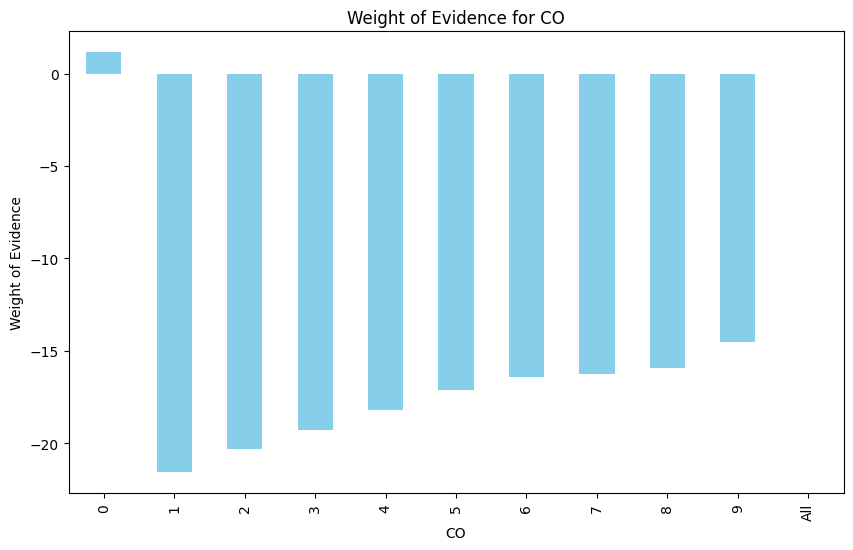

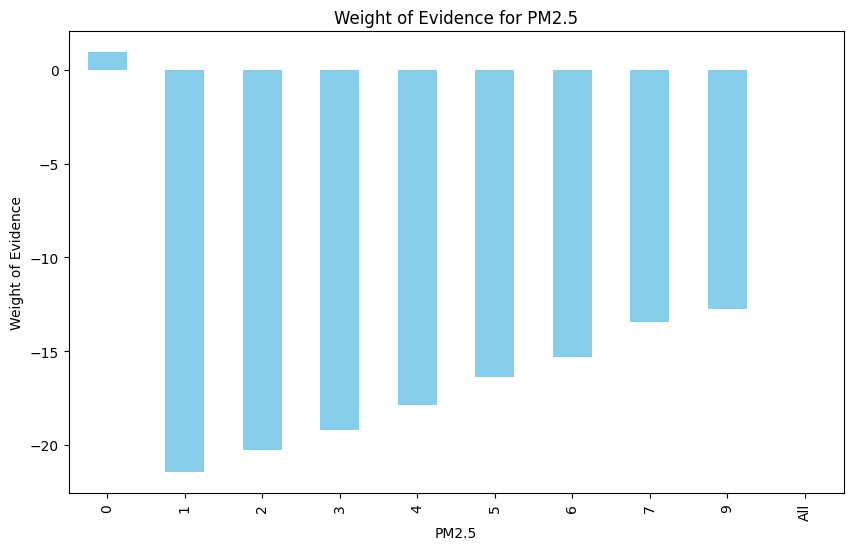

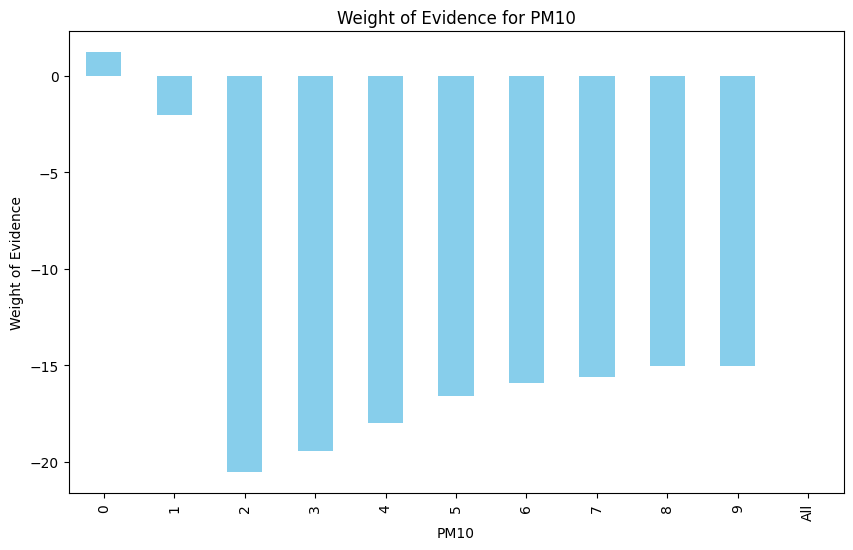

      CO    CO_woe
0  200.0  1.147097
1  200.0  1.147097
2  200.0  1.147097
3  200.0  1.147097
4  200.0  1.147097
   PM2.5  PM2.5_woe
0    4.0   0.938708
1    7.0   0.938708
2    5.0   0.938708
3    6.0   0.938708
4    5.0   0.938708
   PM10  PM10_woe
0   4.0  1.216169
1   7.0  1.216169
2   5.0  1.216169
3   6.0  1.216169
4   5.0  1.216169


In [3]:
def calculate_woe_iv(air_pollution_data, feature, target_variable):
    # Calculate the distribution of good and bad outcomes
    cross_tab = pd.crosstab(air_pollution_data[feature], air_pollution_data[target_variable], margins=True)
    good = cross_tab[0]
    bad = cross_tab[1]

    # Calculate the percentage of good and bad outcomes
    good_dist = (good / good.sum()).fillna(0)
    bad_dist = (bad / bad.sum()).fillna(0)

    # Calculate the WoE
    epsilon = 1e-10
    woe = np.log((good_dist + epsilon) / (bad_dist + epsilon))

    # Calculate the IV
    iv = np.sum((good_dist - bad_dist) * woe)

    # Create a DataFrame to store the results
    woe_iv_table = pd.DataFrame({'WoE': woe, 'IV': (good_dist - bad_dist) * woe})

    print(f'Information Value for {feature}: {iv:.2f}')
    return woe_iv_table

def plot_woe(woe_iv_table, feature):
    plt.figure(figsize=(10, 6))
    woe_iv_table['WoE'].plot(kind='bar', color='skyblue')
    plt.title(f'Weight of Evidence for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Weight of Evidence')
    plt.show()

features = ["year","month","day","hour","PM2.5","PM10","SO2","NO2","CO","O3","TEMP","PRES","DEWP","RAIN","wd","WSPM"]

iv_values = {}
woe_iv_tables = {}

# Calculate WoE and IV for each feature
for feature in features:
    if air_pollution_data[feature].dtype == 'object':
        woe_iv_table = calculate_woe_iv(air_pollution_data, feature, target_variable)
        iv_values[feature] = woe_iv_table['IV'].sum()
        woe_iv_tables[feature] = woe_iv_table # Store
    else:
        # For continuous variables, bin them into intervals
        feature_binned = feature + '_binned'
        air_pollution_data[feature_binned] = pd.cut(air_pollution_data[feature], bins=10, labels=False, duplicates='drop')
        woe_iv_table = calculate_woe_iv(air_pollution_data, feature_binned, target_variable)
        iv_values[feature] = woe_iv_table['IV'].sum()
        woe_iv_tables[feature_binned] = woe_iv_table  # Store

        air_pollution_data.drop(feature_binned, axis=1, inplace=True)

# Determine strongest variables based on IV
strongest_variables = sorted(iv_values, key=iv_values.get, reverse=True)[:3]

# Display WoE graph for strongest variables
print("\nDisplay WoE graph for strongest variables:")
for feature in strongest_variables:
    #Use stored table
    if feature in woe_iv_tables:
        plot_woe(woe_iv_tables[feature], feature)
    else:
        feature_binned = feature + '_binned' #Find binned feature
        plot_woe(woe_iv_tables[feature_binned], feature)

# Group classes by WoE criterion for the strongest variables
for feature in strongest_variables:
    if air_pollution_data[feature].dtype == 'object':
        woe_values = woe_iv_tables[feature]['WoE'].to_dict() #Use stored table
        air_pollution_data[feature + '_woe'] = air_pollution_data[feature].map(woe_values)
    else:
        # For continuous variables, bin them into intervals
        feature_binned = feature + '_binned'
        air_pollution_data[feature_binned] = pd.cut(air_pollution_data[feature], bins=10, labels=False, duplicates='drop')
        woe_values = woe_iv_tables[feature_binned]['WoE'].to_dict() #Use stored table
        air_pollution_data[feature + '_woe'] = air_pollution_data[feature_binned].map(woe_values)
        air_pollution_data.drop(feature_binned, axis=1, inplace=True)

    print(air_pollution_data[[feature, feature + '_woe']].head())

From the analysis we can clearly see that PM2.5, CO and PM10 are the strongest predictors of air quality. High concentration of carbon monoxide is directly linked to bad air quality, most likely sue to vehicle emissions and industrial activity.

Closely followed by NO2, O3 as moderate-strong predictors of bad air quality. Nitrogen dioxide is directly linked to bad air quality, most likely sue to vehicle emissions and industrial activity. Ozone is linked to air pollution, especially when interacting with other pollutants like NO2 in sunny conditions, contributing to bad air quality.

Weak predictors are SO2, DEWP, wd, TEMP and PRES which show minor significance but in certain conditions can have an effect on the bad air quality.

Summary:

Air quality is greatly affected by vehicle emissions and industrial activity, which release harmful particles into the environment, such as SO2, NO2, and CO. Under certain circumstances, O3 can amplify the effects of these other pollutants. When examining the composition of the air, we can categorize it into PM2.5 and PM10, representing fine and coarse particles, respectively. There is a clear connection between the increase in SO2, NO2, and CO, which negatively affects air quality, and by extension, PM2.5 and PM10 levels.

Fortunately, factors such as wind speed and rainfall can help reduce the concentration of harmful particles in the air to some degree. While this is not a complete solution to the problem, it does offer a temporary improvement or brief respite for our health. To resolve the issue in the long term, we must focus on reducing harmful emissions from vehicles and industries.